In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import torch
import pickle

f = open("/content/drive/MyDrive/djup/lokaverkefni/training_data_2019_data_100000_50.dat", "rb")
seen_players, unseen_players, X_seen_train, y_seen_train, X_seen_val, y_seen_val, X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test = pickle.load(f)

## Summary of game tensor

The output of `lcz_features` is explained here. Here, `game[0]` is used for reference.

- `game[0][0]`: Black's pawns
- `game[0][1]`: Black's knights
- `game[0][2]`: Black's bishops
- `game[0][3]`: Black's rooks
- `game[0][4]`: Black's queen
- `game[0][5]`: Black's king
- `game[0][6:11]`: White pieces (in same order as above)
- `game[0][12]`: Channel with only zeros
- `game[0][13:24]`: The board state before the given game was played.
- `game[0][25:111]`: Channels that only include 0 or only include 1. These are to tell if the white pieces may castle and on which sides and if the black pieces can do so, if there are repeated moves, 50 move rule etc.






## Model config


In [3]:
%%capture
!pip install pytorch_lightning torchmetrics wandb python-chess

In [4]:
import os

os.environ["WANDB_NOTEBOOK_NAME"] = "Djúpt lokaverkefni"

In [5]:
import wandb

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find Djúpt lokaverkefni.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [6]:
from pytorch_lightning.loggers import WandbLogger

wandb_logger = WandbLogger()

wandb: Currently logged in as: karirogg (ipynb). Use `wandb login --relogin` to force relogin


## Using Generalized end 2 end loss

In [7]:
def games_to_planes(games, max_moves = 10, black = False):
  """
  Function that takes in a N x n numpy dataframe, where N is the number of games and n is the number of moves
  per game, and returns a 24 x 8 x 8 representation of each move, in tensor form.
  """
  games_planes_list = []
  for game in games:
    board = LeelaBoard()
    current_planes = []
    for i, move in enumerate(game):
      if i == 2*20:
        break
      board.push_uci(str(move))
      current_planes.append(board.lcz_features()[:25])

    # random_idx = sorted(np.random.choice(np.arange(20), max_moves, replace=False))

    if black:
      games_planes_list.append(np.array(current_planes)[::2][np.arange(max_moves)])
    else:
      games_planes_list.append(np.array(current_planes)[1::2][np.arange(max_moves)])

  return torch.tensor(np.array(games_planes_list))

In [8]:
player_white_games = dict()
player_black_games = dict()

used_player_list = []

targets = y_seen_train[:, [0,2]]

for j in np.unique(targets):
  player_white_games[j] = X_seen_train[targets[:,0] == j]
  player_black_games[j] = X_seen_train[targets[:,1] == j]

In [9]:
class Baukur:
  """
  Dataloader for the data. In each iteration, N players are sampled and M games per player. The games are then turned into a planes tensor for model input.
  """
  def __init__(self, games, targets, players, player_white_games, player_black_games, N, M):
    self.games = games
    self.targets = targets
    self.N = N
    self.M = M

    self.players = players

    self.player_white_games = player_white_games
    self.player_black_games = player_black_games

  def __iter__(self):
    return self

  def __next__(self):
    observation_list = []

    selected_players_idx = np.random.choice(range(len(self.players)), self.N)

    for j in self.players[selected_players_idx]:
      selected_games_idx = np.random.choice(range(len(self.player_white_games[j]) + len(self.player_black_games[j])), self.M, replace=False)
      selected_white_games = self.player_white_games[j][selected_games_idx[selected_games_idx < len(self.player_white_games[j])]]
      selected_black_games = self.player_black_games[j][selected_games_idx[selected_games_idx >= len(self.player_white_games[j])] - len(self.player_white_games[j])]

      selected_games_planes = torch.cat((games_to_planes(selected_white_games, black = False), games_to_planes(selected_black_games, black = True)), dim=0)

      observation_list.append(selected_games_planes)

    return torch.stack(observation_list), torch.tensor(self.players)

train_dataloader = iter(Baukur(X_seen_train, y_seen_train[:, [0,2]], seen_players, player_white_games, player_black_games, 40, 20))

In [10]:
#@title LeelaBoard class created

# -*- coding: utf-8 -*-

# uci_to_idx is a list of four dicts {uci -> NN policy index}
# 0 = white, no-castling
# 1 = white, castling
# 2 = black, no-castling
# 3 = black, castling
# Black moves are flipped, and castling moves are mapped to the e8a8, e8h8, e1a1, e1h1 indexes
#  from their respective UCI names

uci_to_idx = []

# The index-to-uci list originates from here:
# https://github.com/glinscott/leela-chess/blob/master/lc0/src/chess/bitboard.cc

# White, no-castling
_idx_to_move_wn = [
    'a1b1', 'a1c1', 'a1d1', 'a1e1', 'a1f1', 'a1g1', 'a1h1',
    'a1a2', 'a1b2', 'a1c2', 'a1a3', 'a1b3', 'a1c3', 'a1a4',
    'a1d4', 'a1a5', 'a1e5', 'a1a6', 'a1f6', 'a1a7', 'a1g7',
    'a1a8', 'a1h8', 'b1a1', 'b1c1', 'b1d1', 'b1e1', 'b1f1',
    'b1g1', 'b1h1', 'b1a2', 'b1b2', 'b1c2', 'b1d2', 'b1a3',
    'b1b3', 'b1c3', 'b1d3', 'b1b4', 'b1e4', 'b1b5', 'b1f5',
    'b1b6', 'b1g6', 'b1b7', 'b1h7', 'b1b8', 'c1a1', 'c1b1',
    'c1d1', 'c1e1', 'c1f1', 'c1g1', 'c1h1', 'c1a2', 'c1b2',
    'c1c2', 'c1d2', 'c1e2', 'c1a3', 'c1b3', 'c1c3', 'c1d3',
    'c1e3', 'c1c4', 'c1f4', 'c1c5', 'c1g5', 'c1c6', 'c1h6',
    'c1c7', 'c1c8', 'd1a1', 'd1b1', 'd1c1', 'd1e1', 'd1f1',
    'd1g1', 'd1h1', 'd1b2', 'd1c2', 'd1d2', 'd1e2', 'd1f2',
    'd1b3', 'd1c3', 'd1d3', 'd1e3', 'd1f3', 'd1a4', 'd1d4',
    'd1g4', 'd1d5', 'd1h5', 'd1d6', 'd1d7', 'd1d8', 'e1a1',
    'e1b1', 'e1c1', 'e1d1', 'e1f1', 'e1g1', 'e1h1', 'e1c2',
    'e1d2', 'e1e2', 'e1f2', 'e1g2', 'e1c3', 'e1d3', 'e1e3',
    'e1f3', 'e1g3', 'e1b4', 'e1e4', 'e1h4', 'e1a5', 'e1e5',
    'e1e6', 'e1e7', 'e1e8', 'f1a1', 'f1b1', 'f1c1', 'f1d1',
    'f1e1', 'f1g1', 'f1h1', 'f1d2', 'f1e2', 'f1f2', 'f1g2',
    'f1h2', 'f1d3', 'f1e3', 'f1f3', 'f1g3', 'f1h3', 'f1c4',
    'f1f4', 'f1b5', 'f1f5', 'f1a6', 'f1f6', 'f1f7', 'f1f8',
    'g1a1', 'g1b1', 'g1c1', 'g1d1', 'g1e1', 'g1f1', 'g1h1',
    'g1e2', 'g1f2', 'g1g2', 'g1h2', 'g1e3', 'g1f3', 'g1g3',
    'g1h3', 'g1d4', 'g1g4', 'g1c5', 'g1g5', 'g1b6', 'g1g6',
    'g1a7', 'g1g7', 'g1g8', 'h1a1', 'h1b1', 'h1c1', 'h1d1',
    'h1e1', 'h1f1', 'h1g1', 'h1f2', 'h1g2', 'h1h2', 'h1f3',
    'h1g3', 'h1h3', 'h1e4', 'h1h4', 'h1d5', 'h1h5', 'h1c6',
    'h1h6', 'h1b7', 'h1h7', 'h1a8', 'h1h8', 'a2a1', 'a2b1',
    'a2c1', 'a2b2', 'a2c2', 'a2d2', 'a2e2', 'a2f2', 'a2g2',
    'a2h2', 'a2a3', 'a2b3', 'a2c3', 'a2a4', 'a2b4', 'a2c4',
    'a2a5', 'a2d5', 'a2a6', 'a2e6', 'a2a7', 'a2f7', 'a2a8',
    'a2g8', 'b2a1', 'b2b1', 'b2c1', 'b2d1', 'b2a2', 'b2c2',
    'b2d2', 'b2e2', 'b2f2', 'b2g2', 'b2h2', 'b2a3', 'b2b3',
    'b2c3', 'b2d3', 'b2a4', 'b2b4', 'b2c4', 'b2d4', 'b2b5',
    'b2e5', 'b2b6', 'b2f6', 'b2b7', 'b2g7', 'b2b8', 'b2h8',
    'c2a1', 'c2b1', 'c2c1', 'c2d1', 'c2e1', 'c2a2', 'c2b2',
    'c2d2', 'c2e2', 'c2f2', 'c2g2', 'c2h2', 'c2a3', 'c2b3',
    'c2c3', 'c2d3', 'c2e3', 'c2a4', 'c2b4', 'c2c4', 'c2d4',
    'c2e4', 'c2c5', 'c2f5', 'c2c6', 'c2g6', 'c2c7', 'c2h7',
    'c2c8', 'd2b1', 'd2c1', 'd2d1', 'd2e1', 'd2f1', 'd2a2',
    'd2b2', 'd2c2', 'd2e2', 'd2f2', 'd2g2', 'd2h2', 'd2b3',
    'd2c3', 'd2d3', 'd2e3', 'd2f3', 'd2b4', 'd2c4', 'd2d4',
    'd2e4', 'd2f4', 'd2a5', 'd2d5', 'd2g5', 'd2d6', 'd2h6',
    'd2d7', 'd2d8', 'e2c1', 'e2d1', 'e2e1', 'e2f1', 'e2g1',
    'e2a2', 'e2b2', 'e2c2', 'e2d2', 'e2f2', 'e2g2', 'e2h2',
    'e2c3', 'e2d3', 'e2e3', 'e2f3', 'e2g3', 'e2c4', 'e2d4',
    'e2e4', 'e2f4', 'e2g4', 'e2b5', 'e2e5', 'e2h5', 'e2a6',
    'e2e6', 'e2e7', 'e2e8', 'f2d1', 'f2e1', 'f2f1', 'f2g1',
    'f2h1', 'f2a2', 'f2b2', 'f2c2', 'f2d2', 'f2e2', 'f2g2',
    'f2h2', 'f2d3', 'f2e3', 'f2f3', 'f2g3', 'f2h3', 'f2d4',
    'f2e4', 'f2f4', 'f2g4', 'f2h4', 'f2c5', 'f2f5', 'f2b6',
    'f2f6', 'f2a7', 'f2f7', 'f2f8', 'g2e1', 'g2f1', 'g2g1',
    'g2h1', 'g2a2', 'g2b2', 'g2c2', 'g2d2', 'g2e2', 'g2f2',
    'g2h2', 'g2e3', 'g2f3', 'g2g3', 'g2h3', 'g2e4', 'g2f4',
    'g2g4', 'g2h4', 'g2d5', 'g2g5', 'g2c6', 'g2g6', 'g2b7',
    'g2g7', 'g2a8', 'g2g8', 'h2f1', 'h2g1', 'h2h1', 'h2a2',
    'h2b2', 'h2c2', 'h2d2', 'h2e2', 'h2f2', 'h2g2', 'h2f3',
    'h2g3', 'h2h3', 'h2f4', 'h2g4', 'h2h4', 'h2e5', 'h2h5',
    'h2d6', 'h2h6', 'h2c7', 'h2h7', 'h2b8', 'h2h8', 'a3a1',
    'a3b1', 'a3c1', 'a3a2', 'a3b2', 'a3c2', 'a3b3', 'a3c3',
    'a3d3', 'a3e3', 'a3f3', 'a3g3', 'a3h3', 'a3a4', 'a3b4',
    'a3c4', 'a3a5', 'a3b5', 'a3c5', 'a3a6', 'a3d6', 'a3a7',
    'a3e7', 'a3a8', 'a3f8', 'b3a1', 'b3b1', 'b3c1', 'b3d1',
    'b3a2', 'b3b2', 'b3c2', 'b3d2', 'b3a3', 'b3c3', 'b3d3',
    'b3e3', 'b3f3', 'b3g3', 'b3h3', 'b3a4', 'b3b4', 'b3c4',
    'b3d4', 'b3a5', 'b3b5', 'b3c5', 'b3d5', 'b3b6', 'b3e6',
    'b3b7', 'b3f7', 'b3b8', 'b3g8', 'c3a1', 'c3b1', 'c3c1',
    'c3d1', 'c3e1', 'c3a2', 'c3b2', 'c3c2', 'c3d2', 'c3e2',
    'c3a3', 'c3b3', 'c3d3', 'c3e3', 'c3f3', 'c3g3', 'c3h3',
    'c3a4', 'c3b4', 'c3c4', 'c3d4', 'c3e4', 'c3a5', 'c3b5',
    'c3c5', 'c3d5', 'c3e5', 'c3c6', 'c3f6', 'c3c7', 'c3g7',
    'c3c8', 'c3h8', 'd3b1', 'd3c1', 'd3d1', 'd3e1', 'd3f1',
    'd3b2', 'd3c2', 'd3d2', 'd3e2', 'd3f2', 'd3a3', 'd3b3',
    'd3c3', 'd3e3', 'd3f3', 'd3g3', 'd3h3', 'd3b4', 'd3c4',
    'd3d4', 'd3e4', 'd3f4', 'd3b5', 'd3c5', 'd3d5', 'd3e5',
    'd3f5', 'd3a6', 'd3d6', 'd3g6', 'd3d7', 'd3h7', 'd3d8',
    'e3c1', 'e3d1', 'e3e1', 'e3f1', 'e3g1', 'e3c2', 'e3d2',
    'e3e2', 'e3f2', 'e3g2', 'e3a3', 'e3b3', 'e3c3', 'e3d3',
    'e3f3', 'e3g3', 'e3h3', 'e3c4', 'e3d4', 'e3e4', 'e3f4',
    'e3g4', 'e3c5', 'e3d5', 'e3e5', 'e3f5', 'e3g5', 'e3b6',
    'e3e6', 'e3h6', 'e3a7', 'e3e7', 'e3e8', 'f3d1', 'f3e1',
    'f3f1', 'f3g1', 'f3h1', 'f3d2', 'f3e2', 'f3f2', 'f3g2',
    'f3h2', 'f3a3', 'f3b3', 'f3c3', 'f3d3', 'f3e3', 'f3g3',
    'f3h3', 'f3d4', 'f3e4', 'f3f4', 'f3g4', 'f3h4', 'f3d5',
    'f3e5', 'f3f5', 'f3g5', 'f3h5', 'f3c6', 'f3f6', 'f3b7',
    'f3f7', 'f3a8', 'f3f8', 'g3e1', 'g3f1', 'g3g1', 'g3h1',
    'g3e2', 'g3f2', 'g3g2', 'g3h2', 'g3a3', 'g3b3', 'g3c3',
    'g3d3', 'g3e3', 'g3f3', 'g3h3', 'g3e4', 'g3f4', 'g3g4',
    'g3h4', 'g3e5', 'g3f5', 'g3g5', 'g3h5', 'g3d6', 'g3g6',
    'g3c7', 'g3g7', 'g3b8', 'g3g8', 'h3f1', 'h3g1', 'h3h1',
    'h3f2', 'h3g2', 'h3h2', 'h3a3', 'h3b3', 'h3c3', 'h3d3',
    'h3e3', 'h3f3', 'h3g3', 'h3f4', 'h3g4', 'h3h4', 'h3f5',
    'h3g5', 'h3h5', 'h3e6', 'h3h6', 'h3d7', 'h3h7', 'h3c8',
    'h3h8', 'a4a1', 'a4d1', 'a4a2', 'a4b2', 'a4c2', 'a4a3',
    'a4b3', 'a4c3', 'a4b4', 'a4c4', 'a4d4', 'a4e4', 'a4f4',
    'a4g4', 'a4h4', 'a4a5', 'a4b5', 'a4c5', 'a4a6', 'a4b6',
    'a4c6', 'a4a7', 'a4d7', 'a4a8', 'a4e8', 'b4b1', 'b4e1',
    'b4a2', 'b4b2', 'b4c2', 'b4d2', 'b4a3', 'b4b3', 'b4c3',
    'b4d3', 'b4a4', 'b4c4', 'b4d4', 'b4e4', 'b4f4', 'b4g4',
    'b4h4', 'b4a5', 'b4b5', 'b4c5', 'b4d5', 'b4a6', 'b4b6',
    'b4c6', 'b4d6', 'b4b7', 'b4e7', 'b4b8', 'b4f8', 'c4c1',
    'c4f1', 'c4a2', 'c4b2', 'c4c2', 'c4d2', 'c4e2', 'c4a3',
    'c4b3', 'c4c3', 'c4d3', 'c4e3', 'c4a4', 'c4b4', 'c4d4',
    'c4e4', 'c4f4', 'c4g4', 'c4h4', 'c4a5', 'c4b5', 'c4c5',
    'c4d5', 'c4e5', 'c4a6', 'c4b6', 'c4c6', 'c4d6', 'c4e6',
    'c4c7', 'c4f7', 'c4c8', 'c4g8', 'd4a1', 'd4d1', 'd4g1',
    'd4b2', 'd4c2', 'd4d2', 'd4e2', 'd4f2', 'd4b3', 'd4c3',
    'd4d3', 'd4e3', 'd4f3', 'd4a4', 'd4b4', 'd4c4', 'd4e4',
    'd4f4', 'd4g4', 'd4h4', 'd4b5', 'd4c5', 'd4d5', 'd4e5',
    'd4f5', 'd4b6', 'd4c6', 'd4d6', 'd4e6', 'd4f6', 'd4a7',
    'd4d7', 'd4g7', 'd4d8', 'd4h8', 'e4b1', 'e4e1', 'e4h1',
    'e4c2', 'e4d2', 'e4e2', 'e4f2', 'e4g2', 'e4c3', 'e4d3',
    'e4e3', 'e4f3', 'e4g3', 'e4a4', 'e4b4', 'e4c4', 'e4d4',
    'e4f4', 'e4g4', 'e4h4', 'e4c5', 'e4d5', 'e4e5', 'e4f5',
    'e4g5', 'e4c6', 'e4d6', 'e4e6', 'e4f6', 'e4g6', 'e4b7',
    'e4e7', 'e4h7', 'e4a8', 'e4e8', 'f4c1', 'f4f1', 'f4d2',
    'f4e2', 'f4f2', 'f4g2', 'f4h2', 'f4d3', 'f4e3', 'f4f3',
    'f4g3', 'f4h3', 'f4a4', 'f4b4', 'f4c4', 'f4d4', 'f4e4',
    'f4g4', 'f4h4', 'f4d5', 'f4e5', 'f4f5', 'f4g5', 'f4h5',
    'f4d6', 'f4e6', 'f4f6', 'f4g6', 'f4h6', 'f4c7', 'f4f7',
    'f4b8', 'f4f8', 'g4d1', 'g4g1', 'g4e2', 'g4f2', 'g4g2',
    'g4h2', 'g4e3', 'g4f3', 'g4g3', 'g4h3', 'g4a4', 'g4b4',
    'g4c4', 'g4d4', 'g4e4', 'g4f4', 'g4h4', 'g4e5', 'g4f5',
    'g4g5', 'g4h5', 'g4e6', 'g4f6', 'g4g6', 'g4h6', 'g4d7',
    'g4g7', 'g4c8', 'g4g8', 'h4e1', 'h4h1', 'h4f2', 'h4g2',
    'h4h2', 'h4f3', 'h4g3', 'h4h3', 'h4a4', 'h4b4', 'h4c4',
    'h4d4', 'h4e4', 'h4f4', 'h4g4', 'h4f5', 'h4g5', 'h4h5',
    'h4f6', 'h4g6', 'h4h6', 'h4e7', 'h4h7', 'h4d8', 'h4h8',
    'a5a1', 'a5e1', 'a5a2', 'a5d2', 'a5a3', 'a5b3', 'a5c3',
    'a5a4', 'a5b4', 'a5c4', 'a5b5', 'a5c5', 'a5d5', 'a5e5',
    'a5f5', 'a5g5', 'a5h5', 'a5a6', 'a5b6', 'a5c6', 'a5a7',
    'a5b7', 'a5c7', 'a5a8', 'a5d8', 'b5b1', 'b5f1', 'b5b2',
    'b5e2', 'b5a3', 'b5b3', 'b5c3', 'b5d3', 'b5a4', 'b5b4',
    'b5c4', 'b5d4', 'b5a5', 'b5c5', 'b5d5', 'b5e5', 'b5f5',
    'b5g5', 'b5h5', 'b5a6', 'b5b6', 'b5c6', 'b5d6', 'b5a7',
    'b5b7', 'b5c7', 'b5d7', 'b5b8', 'b5e8', 'c5c1', 'c5g1',
    'c5c2', 'c5f2', 'c5a3', 'c5b3', 'c5c3', 'c5d3', 'c5e3',
    'c5a4', 'c5b4', 'c5c4', 'c5d4', 'c5e4', 'c5a5', 'c5b5',
    'c5d5', 'c5e5', 'c5f5', 'c5g5', 'c5h5', 'c5a6', 'c5b6',
    'c5c6', 'c5d6', 'c5e6', 'c5a7', 'c5b7', 'c5c7', 'c5d7',
    'c5e7', 'c5c8', 'c5f8', 'd5d1', 'd5h1', 'd5a2', 'd5d2',
    'd5g2', 'd5b3', 'd5c3', 'd5d3', 'd5e3', 'd5f3', 'd5b4',
    'd5c4', 'd5d4', 'd5e4', 'd5f4', 'd5a5', 'd5b5', 'd5c5',
    'd5e5', 'd5f5', 'd5g5', 'd5h5', 'd5b6', 'd5c6', 'd5d6',
    'd5e6', 'd5f6', 'd5b7', 'd5c7', 'd5d7', 'd5e7', 'd5f7',
    'd5a8', 'd5d8', 'd5g8', 'e5a1', 'e5e1', 'e5b2', 'e5e2',
    'e5h2', 'e5c3', 'e5d3', 'e5e3', 'e5f3', 'e5g3', 'e5c4',
    'e5d4', 'e5e4', 'e5f4', 'e5g4', 'e5a5', 'e5b5', 'e5c5',
    'e5d5', 'e5f5', 'e5g5', 'e5h5', 'e5c6', 'e5d6', 'e5e6',
    'e5f6', 'e5g6', 'e5c7', 'e5d7', 'e5e7', 'e5f7', 'e5g7',
    'e5b8', 'e5e8', 'e5h8', 'f5b1', 'f5f1', 'f5c2', 'f5f2',
    'f5d3', 'f5e3', 'f5f3', 'f5g3', 'f5h3', 'f5d4', 'f5e4',
    'f5f4', 'f5g4', 'f5h4', 'f5a5', 'f5b5', 'f5c5', 'f5d5',
    'f5e5', 'f5g5', 'f5h5', 'f5d6', 'f5e6', 'f5f6', 'f5g6',
    'f5h6', 'f5d7', 'f5e7', 'f5f7', 'f5g7', 'f5h7', 'f5c8',
    'f5f8', 'g5c1', 'g5g1', 'g5d2', 'g5g2', 'g5e3', 'g5f3',
    'g5g3', 'g5h3', 'g5e4', 'g5f4', 'g5g4', 'g5h4', 'g5a5',
    'g5b5', 'g5c5', 'g5d5', 'g5e5', 'g5f5', 'g5h5', 'g5e6',
    'g5f6', 'g5g6', 'g5h6', 'g5e7', 'g5f7', 'g5g7', 'g5h7',
    'g5d8', 'g5g8', 'h5d1', 'h5h1', 'h5e2', 'h5h2', 'h5f3',
    'h5g3', 'h5h3', 'h5f4', 'h5g4', 'h5h4', 'h5a5', 'h5b5',
    'h5c5', 'h5d5', 'h5e5', 'h5f5', 'h5g5', 'h5f6', 'h5g6',
    'h5h6', 'h5f7', 'h5g7', 'h5h7', 'h5e8', 'h5h8', 'a6a1',
    'a6f1', 'a6a2', 'a6e2', 'a6a3', 'a6d3', 'a6a4', 'a6b4',
    'a6c4', 'a6a5', 'a6b5', 'a6c5', 'a6b6', 'a6c6', 'a6d6',
    'a6e6', 'a6f6', 'a6g6', 'a6h6', 'a6a7', 'a6b7', 'a6c7',
    'a6a8', 'a6b8', 'a6c8', 'b6b1', 'b6g1', 'b6b2', 'b6f2',
    'b6b3', 'b6e3', 'b6a4', 'b6b4', 'b6c4', 'b6d4', 'b6a5',
    'b6b5', 'b6c5', 'b6d5', 'b6a6', 'b6c6', 'b6d6', 'b6e6',
    'b6f6', 'b6g6', 'b6h6', 'b6a7', 'b6b7', 'b6c7', 'b6d7',
    'b6a8', 'b6b8', 'b6c8', 'b6d8', 'c6c1', 'c6h1', 'c6c2',
    'c6g2', 'c6c3', 'c6f3', 'c6a4', 'c6b4', 'c6c4', 'c6d4',
    'c6e4', 'c6a5', 'c6b5', 'c6c5', 'c6d5', 'c6e5', 'c6a6',
    'c6b6', 'c6d6', 'c6e6', 'c6f6', 'c6g6', 'c6h6', 'c6a7',
    'c6b7', 'c6c7', 'c6d7', 'c6e7', 'c6a8', 'c6b8', 'c6c8',
    'c6d8', 'c6e8', 'd6d1', 'd6d2', 'd6h2', 'd6a3', 'd6d3',
    'd6g3', 'd6b4', 'd6c4', 'd6d4', 'd6e4', 'd6f4', 'd6b5',
    'd6c5', 'd6d5', 'd6e5', 'd6f5', 'd6a6', 'd6b6', 'd6c6',
    'd6e6', 'd6f6', 'd6g6', 'd6h6', 'd6b7', 'd6c7', 'd6d7',
    'd6e7', 'd6f7', 'd6b8', 'd6c8', 'd6d8', 'd6e8', 'd6f8',
    'e6e1', 'e6a2', 'e6e2', 'e6b3', 'e6e3', 'e6h3', 'e6c4',
    'e6d4', 'e6e4', 'e6f4', 'e6g4', 'e6c5', 'e6d5', 'e6e5',
    'e6f5', 'e6g5', 'e6a6', 'e6b6', 'e6c6', 'e6d6', 'e6f6',
    'e6g6', 'e6h6', 'e6c7', 'e6d7', 'e6e7', 'e6f7', 'e6g7',
    'e6c8', 'e6d8', 'e6e8', 'e6f8', 'e6g8', 'f6a1', 'f6f1',
    'f6b2', 'f6f2', 'f6c3', 'f6f3', 'f6d4', 'f6e4', 'f6f4',
    'f6g4', 'f6h4', 'f6d5', 'f6e5', 'f6f5', 'f6g5', 'f6h5',
    'f6a6', 'f6b6', 'f6c6', 'f6d6', 'f6e6', 'f6g6', 'f6h6',
    'f6d7', 'f6e7', 'f6f7', 'f6g7', 'f6h7', 'f6d8', 'f6e8',
    'f6f8', 'f6g8', 'f6h8', 'g6b1', 'g6g1', 'g6c2', 'g6g2',
    'g6d3', 'g6g3', 'g6e4', 'g6f4', 'g6g4', 'g6h4', 'g6e5',
    'g6f5', 'g6g5', 'g6h5', 'g6a6', 'g6b6', 'g6c6', 'g6d6',
    'g6e6', 'g6f6', 'g6h6', 'g6e7', 'g6f7', 'g6g7', 'g6h7',
    'g6e8', 'g6f8', 'g6g8', 'g6h8', 'h6c1', 'h6h1', 'h6d2',
    'h6h2', 'h6e3', 'h6h3', 'h6f4', 'h6g4', 'h6h4', 'h6f5',
    'h6g5', 'h6h5', 'h6a6', 'h6b6', 'h6c6', 'h6d6', 'h6e6',
    'h6f6', 'h6g6', 'h6f7', 'h6g7', 'h6h7', 'h6f8', 'h6g8',
    'h6h8', 'a7a1', 'a7g1', 'a7a2', 'a7f2', 'a7a3', 'a7e3',
    'a7a4', 'a7d4', 'a7a5', 'a7b5', 'a7c5', 'a7a6', 'a7b6',
    'a7c6', 'a7b7', 'a7c7', 'a7d7', 'a7e7', 'a7f7', 'a7g7',
    'a7h7', 'a7a8', 'a7b8', 'a7c8', 'b7b1', 'b7h1', 'b7b2',
    'b7g2', 'b7b3', 'b7f3', 'b7b4', 'b7e4', 'b7a5', 'b7b5',
    'b7c5', 'b7d5', 'b7a6', 'b7b6', 'b7c6', 'b7d6', 'b7a7',
    'b7c7', 'b7d7', 'b7e7', 'b7f7', 'b7g7', 'b7h7', 'b7a8',
    'b7b8', 'b7c8', 'b7d8', 'c7c1', 'c7c2', 'c7h2', 'c7c3',
    'c7g3', 'c7c4', 'c7f4', 'c7a5', 'c7b5', 'c7c5', 'c7d5',
    'c7e5', 'c7a6', 'c7b6', 'c7c6', 'c7d6', 'c7e6', 'c7a7',
    'c7b7', 'c7d7', 'c7e7', 'c7f7', 'c7g7', 'c7h7', 'c7a8',
    'c7b8', 'c7c8', 'c7d8', 'c7e8', 'd7d1', 'd7d2', 'd7d3',
    'd7h3', 'd7a4', 'd7d4', 'd7g4', 'd7b5', 'd7c5', 'd7d5',
    'd7e5', 'd7f5', 'd7b6', 'd7c6', 'd7d6', 'd7e6', 'd7f6',
    'd7a7', 'd7b7', 'd7c7', 'd7e7', 'd7f7', 'd7g7', 'd7h7',
    'd7b8', 'd7c8', 'd7d8', 'd7e8', 'd7f8', 'e7e1', 'e7e2',
    'e7a3', 'e7e3', 'e7b4', 'e7e4', 'e7h4', 'e7c5', 'e7d5',
    'e7e5', 'e7f5', 'e7g5', 'e7c6', 'e7d6', 'e7e6', 'e7f6',
    'e7g6', 'e7a7', 'e7b7', 'e7c7', 'e7d7', 'e7f7', 'e7g7',
    'e7h7', 'e7c8', 'e7d8', 'e7e8', 'e7f8', 'e7g8', 'f7f1',
    'f7a2', 'f7f2', 'f7b3', 'f7f3', 'f7c4', 'f7f4', 'f7d5',
    'f7e5', 'f7f5', 'f7g5', 'f7h5', 'f7d6', 'f7e6', 'f7f6',
    'f7g6', 'f7h6', 'f7a7', 'f7b7', 'f7c7', 'f7d7', 'f7e7',
    'f7g7', 'f7h7', 'f7d8', 'f7e8', 'f7f8', 'f7g8', 'f7h8',
    'g7a1', 'g7g1', 'g7b2', 'g7g2', 'g7c3', 'g7g3', 'g7d4',
    'g7g4', 'g7e5', 'g7f5', 'g7g5', 'g7h5', 'g7e6', 'g7f6',
    'g7g6', 'g7h6', 'g7a7', 'g7b7', 'g7c7', 'g7d7', 'g7e7',
    'g7f7', 'g7h7', 'g7e8', 'g7f8', 'g7g8', 'g7h8', 'h7b1',
    'h7h1', 'h7c2', 'h7h2', 'h7d3', 'h7h3', 'h7e4', 'h7h4',
    'h7f5', 'h7g5', 'h7h5', 'h7f6', 'h7g6', 'h7h6', 'h7a7',
    'h7b7', 'h7c7', 'h7d7', 'h7e7', 'h7f7', 'h7g7', 'h7f8',
    'h7g8', 'h7h8', 'a8a1', 'a8h1', 'a8a2', 'a8g2', 'a8a3',
    'a8f3', 'a8a4', 'a8e4', 'a8a5', 'a8d5', 'a8a6', 'a8b6',
    'a8c6', 'a8a7', 'a8b7', 'a8c7', 'a8b8', 'a8c8', 'a8d8',
    'a8e8', 'a8f8', 'a8g8', 'a8h8', 'b8b1', 'b8b2', 'b8h2',
    'b8b3', 'b8g3', 'b8b4', 'b8f4', 'b8b5', 'b8e5', 'b8a6',
    'b8b6', 'b8c6', 'b8d6', 'b8a7', 'b8b7', 'b8c7', 'b8d7',
    'b8a8', 'b8c8', 'b8d8', 'b8e8', 'b8f8', 'b8g8', 'b8h8',
    'c8c1', 'c8c2', 'c8c3', 'c8h3', 'c8c4', 'c8g4', 'c8c5',
    'c8f5', 'c8a6', 'c8b6', 'c8c6', 'c8d6', 'c8e6', 'c8a7',
    'c8b7', 'c8c7', 'c8d7', 'c8e7', 'c8a8', 'c8b8', 'c8d8',
    'c8e8', 'c8f8', 'c8g8', 'c8h8', 'd8d1', 'd8d2', 'd8d3',
    'd8d4', 'd8h4', 'd8a5', 'd8d5', 'd8g5', 'd8b6', 'd8c6',
    'd8d6', 'd8e6', 'd8f6', 'd8b7', 'd8c7', 'd8d7', 'd8e7',
    'd8f7', 'd8a8', 'd8b8', 'd8c8', 'd8e8', 'd8f8', 'd8g8',
    'd8h8', 'e8e1', 'e8e2', 'e8e3', 'e8a4', 'e8e4', 'e8b5',
    'e8e5', 'e8h5', 'e8c6', 'e8d6', 'e8e6', 'e8f6', 'e8g6',
    'e8c7', 'e8d7', 'e8e7', 'e8f7', 'e8g7', 'e8a8', 'e8b8',
    'e8c8', 'e8d8', 'e8f8', 'e8g8', 'e8h8', 'f8f1', 'f8f2',
    'f8a3', 'f8f3', 'f8b4', 'f8f4', 'f8c5', 'f8f5', 'f8d6',
    'f8e6', 'f8f6', 'f8g6', 'f8h6', 'f8d7', 'f8e7', 'f8f7',
    'f8g7', 'f8h7', 'f8a8', 'f8b8', 'f8c8', 'f8d8', 'f8e8',
    'f8g8', 'f8h8', 'g8g1', 'g8a2', 'g8g2', 'g8b3', 'g8g3',
    'g8c4', 'g8g4', 'g8d5', 'g8g5', 'g8e6', 'g8f6', 'g8g6',
    'g8h6', 'g8e7', 'g8f7', 'g8g7', 'g8h7', 'g8a8', 'g8b8',
    'g8c8', 'g8d8', 'g8e8', 'g8f8', 'g8h8', 'h8a1', 'h8h1',
    'h8b2', 'h8h2', 'h8c3', 'h8h3', 'h8d4', 'h8h4', 'h8e5',
    'h8h5', 'h8f6', 'h8g6', 'h8h6', 'h8f7', 'h8g7', 'h8h7',
    'h8a8', 'h8b8', 'h8c8', 'h8d8', 'h8e8', 'h8f8', 'h8g8',
    'a7a8q', 'a7a8r', 'a7a8b', 'a7b8q', 'a7b8r', 'a7b8b', 'b7a8q',
    'b7a8r', 'b7a8b', 'b7b8q', 'b7b8r', 'b7b8b', 'b7c8q', 'b7c8r',
    'b7c8b', 'c7b8q', 'c7b8r', 'c7b8b', 'c7c8q', 'c7c8r', 'c7c8b',
    'c7d8q', 'c7d8r', 'c7d8b', 'd7c8q', 'd7c8r', 'd7c8b', 'd7d8q',
    'd7d8r', 'd7d8b', 'd7e8q', 'd7e8r', 'd7e8b', 'e7d8q', 'e7d8r',
    'e7d8b', 'e7e8q', 'e7e8r', 'e7e8b', 'e7f8q', 'e7f8r', 'e7f8b',
    'f7e8q', 'f7e8r', 'f7e8b', 'f7f8q', 'f7f8r', 'f7f8b', 'f7g8q',
    'f7g8r', 'f7g8b', 'g7f8q', 'g7f8r', 'g7f8b', 'g7g8q', 'g7g8r',
    'g7g8b', 'g7h8q', 'g7h8r', 'g7h8b', 'h7g8q', 'h7g8r', 'h7g8b',
    'h7h8q', 'h7h8r', 'h7h8b'
]

# White, no castling
_uci_to_idx_wn = dict((uci, idx) for idx, uci in enumerate(_idx_to_move_wn))

# White, castling
_uci_to_idx_wc = dict((uci, idx) for idx, uci in enumerate(_idx_to_move_wn))
_uci_to_idx_wc['e1g1'], _uci_to_idx_wc['e1h1'] = _uci_to_idx_wc['e1h1'], _uci_to_idx_wc['e1g1']
_uci_to_idx_wc['e1c1'], _uci_to_idx_wc['e1a1'] = _uci_to_idx_wc['e1a1'], _uci_to_idx_wc['e1c1'] 


# Black, no castling
_idx_to_move_bn = []
for move in _idx_to_move_wn:
    c0,r0,c1,r1,p = move[0],int(move[1]),move[2],int(move[3]),move[4:]
    r0 = 9 - r0
    r1 = 9 - r1
    _idx_to_move_bn.append('{}{}{}{}{}'.format(c0,r0,c1,r1,p))
_uci_to_idx_bn = dict((uci, idx) for idx, uci in enumerate(_idx_to_move_bn))

# Black, castling
_uci_to_idx_bc = dict((uci, idx) for idx, uci in enumerate(_idx_to_move_bn))
_uci_to_idx_bc['e8g8'], _uci_to_idx_bc['e8h8'] = _uci_to_idx_bc['e8h8'], _uci_to_idx_bc['e8g8']
_uci_to_idx_bc['e8c8'], _uci_to_idx_bc['e8a8'] = _uci_to_idx_bc['e8a8'], _uci_to_idx_bc['e8c8'] 

_uci_to_idx = [_uci_to_idx_wn, _uci_to_idx_wc, _uci_to_idx_bn, _uci_to_idx_bc]

import collections
import numpy as np
import chess
from chess import Move
import struct
# from lcztools._uci_to_idx import uci_to_idx as _uci_to_idx
import zlib

flat_planes = []
for i in range(256):
    flat_planes.append(np.ones((8,8), dtype=np.uint8)*i)

LeelaBoardData = collections.namedtuple('LeelaBoardData',
                            'plane_bytes repetition '
                            'transposition_key us_ooo us_oo them_ooo them_oo '
                            'side_to_move rule50_count')

def pc_board_property(propertyname):
    '''Create a property based on self.pc_board'''
    def prop(self):
        return getattr(self.pc_board, propertyname)
    return property(prop)
    
class LeelaBoard:
    turn = pc_board_property('turn')
    move_stack = pc_board_property('move_stack')
    _plane_bytes_struct = struct.Struct('>Q')
    
    def __init__(self, leela_board = None, *args, **kwargs):
        '''If leela_board is passed as an argument, return a copy'''
        self.pc_board = chess.Board(*args, **kwargs)
        self.lcz_stack = []
        self._lcz_transposition_counter = collections.Counter()
        self._lcz_push()
        self.is_game_over = self.pc_method('is_game_over')
        self.can_claim_draw = self.pc_method('can_claim_draw')
        self.generate_legal_moves = self.pc_method('generate_legal_moves')
                
    def copy(self, history=7):
        """Note! Currently the copy constructor uses pc_board.copy(stack=False), which makes pops impossible"""
        cls = type(self)
        copied = cls.__new__(cls)
        copied.pc_board = self.pc_board.copy(stack=False)
        copied.pc_board.stack[:] = self.pc_board.stack[-history:]
        copied.pc_board.move_stack[:] = self.pc_board.move_stack[-history:]
        copied.lcz_stack = self.lcz_stack[-history:]
        copied._lcz_transposition_counter = self._lcz_transposition_counter.copy()
        copied.is_game_over = copied.pc_method('is_game_over')
        copied.can_claim_draw = copied.pc_method('can_claim_draw')
        copied.generate_legal_moves = copied.pc_method('generate_legal_moves')        
        return copied

    def pc_method(self, methodname):
        '''Return attribute of self.pc_board, useful for copying method bindings'''
        return getattr(self.pc_board, methodname)
    
    def is_threefold(self):
        transposition_key = self.pc_board._transposition_key()
        return self._lcz_transposition_counter[transposition_key] >= 3
    
    def is_fifty_moves(self):
        return self.pc_board.halfmove_clock >= 100
    
    def is_draw(self):
        return self.is_threefold() or self.is_fifty_moves()

    def push(self, move):
        self.pc_board.push(move)
        self._lcz_push()

    def push_uci(self, uci):
        # don't check for legality - it takes much longer to run...
        # self.pc_board.push_uci(uci)
        self.pc_board.push(Move.from_uci(uci))
        self._lcz_push()

    def push_san(self, san):
        self.pc_board.push_san(san)
        self._lcz_push()

    def pop(self):
        result = self.pc_board.pop()
        _lcz_data = self.lcz_stack.pop()
        self._lcz_transposition_counter.subtract((_lcz_data.transposition_key,))
        return result

    def _plane_bytes_iter(self):
        """Get plane bytes... used for _lcz_push"""
        pack = self._plane_bytes_struct.pack
        pieces_mask = self.pc_board.pieces_mask
        for color in (True, False):
            for piece_type in range(1,7):
                byts = pack(pieces_mask(piece_type, color))
                yield byts

    def _lcz_push(self):
        """Push data onto the lcz data stack after pushing board moves"""
        transposition_key = self.pc_board._transposition_key()
        self._lcz_transposition_counter.update((transposition_key,))
        repetitions = self._lcz_transposition_counter[transposition_key] - 1
        # side_to_move = 0 if we're white, 1 if we're black
        side_to_move = 0 if self.pc_board.turn else 1
        rule50_count = self.pc_board.halfmove_clock
        # Figure out castling rights
        if not side_to_move:
            # we're white
            _c = self.pc_board.castling_rights
            us_ooo, us_oo = (_c>>chess.A1) & 1, (_c>>chess.H1) & 1
            them_ooo, them_oo = (_c>>chess.A8) & 1, (_c>>chess.H8) & 1
        else: 
            # We're black
            _c = self.pc_board.castling_rights
            us_ooo, us_oo = (_c>>chess.A8) & 1, (_c>>chess.H8) & 1
            them_ooo, them_oo = (_c>>chess.A1) & 1, (_c>>chess.H1) & 1
        # Create 13 planes... 6 us, 6 them, repetitions>=1
        plane_bytes = b''.join(self._plane_bytes_iter())
        repetition = (repetitions>=1)
        lcz_data = LeelaBoardData(
            plane_bytes, repetition=repetition,
            transposition_key=transposition_key,
            us_ooo=us_ooo, us_oo=us_oo, them_ooo=them_ooo, them_oo=them_oo,
            side_to_move=side_to_move, rule50_count=rule50_count
        )
        self.lcz_stack.append(lcz_data)
        
    def serialize_features(self):
        '''Get compacted bytes representation of input planes'''
        planes = []
        curdata = self.lcz_stack[-1]
        bytes_false_true = bytes([False]), bytes([True])
        bytes_per_history = 97
        total_plane_bytes = bytes_per_history * 8
        def bytes_iter():
            plane_bytes_yielded = 0
            for data in self.lcz_stack[-1:-9:-1]:
                yield data.plane_bytes
                yield bytes_false_true[data.repetition]
                plane_bytes_yielded += bytes_per_history
            # 104 total piece planes... fill in missing with 0s
            yield bytes(total_plane_bytes - plane_bytes_yielded)
            # Yield the rest of the constant planes
            yield np.packbits((curdata.us_ooo,
                             curdata.us_oo,
                             curdata.them_ooo,
                             curdata.them_oo,
                             curdata.side_to_move)).tobytes()
            yield chr(curdata.rule50_count).encode()
        return b''.join(bytes_iter())
    
    @classmethod
    def deserialize_features(cls, serialized):
        planes_stack = []
        rule50_count = serialized[-1]  # last byte is rule 50
        board_attrs = np.unpackbits(memoryview(serialized[-2:-1]))  # second to last byte
        us_ooo, us_oo, them_ooo, them_oo, side_to_move = board_attrs[:5]
        bytes_per_history = 97
        for history_idx in range(0, bytes_per_history*8, bytes_per_history):
            plane_bytes = serialized[history_idx:history_idx+96]
            repetition = serialized[history_idx+96]
            if not side_to_move:
                # we're white
                planes = (np.unpackbits(memoryview(plane_bytes))[::-1]
                                        .reshape(12, 8, 8)[::-1])                
            else:
                # We're black
                planes = (np.unpackbits(memoryview(plane_bytes))[::-1]
                                        .reshape(12, 8, 8)[::-1]
                                        .reshape(2,6,8,8)[::-1,:,::-1]
                                        .reshape(12, 8,8))
            planes_stack.append(planes)
            planes_stack.append([flat_planes[repetition]])
        planes_stack.append([flat_planes[us_ooo],
            flat_planes[us_oo],
            flat_planes[them_ooo],
            flat_planes[them_oo],
            flat_planes[side_to_move],
            flat_planes[rule50_count],
            flat_planes[0],
            flat_planes[1]])     
        planes = np.concatenate(planes_stack)
        return planes                
        
    def lcz_features(self):
        '''Get neural network input planes as uint8'''
        # print(list(self._planes_iter()))
        planes_stack = []
        curdata = self.lcz_stack[-1]
        planes_yielded = 0
        for data in self.lcz_stack[-1:-9:-1]:
            plane_bytes = data.plane_bytes
            if not curdata.side_to_move:
                # we're white
                planes = (np.unpackbits(memoryview(plane_bytes))[::-1]
                                        .reshape(12, 8, 8)[::-1])                
            else:
                # We're black
                planes = (np.unpackbits(memoryview(plane_bytes))[::-1]
                                        .reshape(12, 8, 8)[::-1]
                                        .reshape(2,6,8,8)[::-1,:,::-1]
                                        .reshape(12, 8,8))
            planes_stack.append(planes)
            planes_stack.append([flat_planes[data.repetition]])
            planes_yielded += 13
        empty_planes = [flat_planes[0] for _ in range(104-planes_yielded)]
        if empty_planes:
            planes_stack.append(empty_planes)
        # Yield the rest of the constant planes
        planes_stack.append([flat_planes[curdata.us_ooo],
            flat_planes[curdata.us_oo],
            flat_planes[curdata.them_ooo],
            flat_planes[curdata.them_oo],
            flat_planes[curdata.side_to_move],
            flat_planes[curdata.rule50_count],
            flat_planes[0],
            flat_planes[1]])     
        planes = np.concatenate(planes_stack)
        return planes

    def lcz_uci_to_idx(self, uci_list):
        # Return list of NN policy output indexes for this board position, given uci_list
        
        # TODO: Perhaps it's possible to just add the uci knight promotion move to the index dict
        # currently knight promotions are not in the dict 
        uci_list = [uci.rstrip('n') for uci in uci_list]
        
        data = self.lcz_stack[-1]
        # uci_to_idx_index =
        #  White, no-castling => 0
        #  White, castling => 1
        #  Black, no-castling => 2
        #  Black, castling => 3
        uci_to_idx_index = (data.us_ooo | data.us_oo) +  2*data.side_to_move
        uci_idx_dct = _uci_to_idx[uci_to_idx_index]
        return [uci_idx_dct[m] for m in uci_list]
    
    @classmethod
    def compress_features(cls, features):
        """Compress a features array as returned from lcz_features method"""
        features_8 = features.astype(np.uint8)
        # Simple compression would do this...
        # return zlib.compress(features_8)
        piece_plane_bytes = np.packbits(features_8[:-8]).tobytes()
        scalar_bytes = features_8[-8:][:,0,0].tobytes()
        compressed = zlib.compress(piece_plane_bytes + scalar_bytes)
        return compressed
    
    @classmethod
    def decompress_features(cls, compressed_features):
        """Decompress a compressed features array from compress_features"""
        decompressed = zlib.decompress(compressed_features)
        # Simple decompression would do this
        # return np.frombuffer(decompressed, dtype=np.uint8).astype(np.float32).reshape(-1,8,8)
        piece_plane_bytes = decompressed[:-8]
        scalar_bytes = decompressed[-8:]
        piece_plane_arr = np.unpackbits(memoryview(piece_plane_bytes))
        scalar_arr = np.frombuffer(scalar_bytes, dtype=np.uint8).repeat(64)
        result = np.concatenate((piece_plane_arr, scalar_arr)).astype(np.float32).reshape(-1,8,8)
        return result
    
    def unicode(self):
        if self.pc_board.is_game_over() or self.is_draw():
            result = self.pc_board.result(claim_draw=True)
            turnstring = 'Result: {}'.format(result)
        else:
            turnstring = 'Turn: {}'.format('White' if self.pc_board.turn else 'Black') 
        boardstr = self.pc_board.unicode() + "\n" + turnstring
        return boardstr

    def __repr__(self):
        return "LeelaBoard('{}')".format(self.pc_board.fen())

    def _repr_svg_(self):
        return self.pc_board._repr_svg_()

    def __str__(self):
        if self.pc_board.is_game_over() or self.is_draw():
            result = self.pc_board.result(claim_draw=True)
            turnstring = 'Result: {}'.format(result)
        else:
            turnstring = 'Turn: {}'.format('White' if self.pc_board.turn else 'Black') 
        boardstr = self.pc_board.__str__() + "\n" + turnstring
        return boardstr
    
    def __eq__(self, other):
        return self.get_hash_key() == other.get_hash_key()
    
    def __hash__(self):
        return hash(self.get_hash_key())

    def get_hash_key(self):
        transposition_key = self.pc_board._transposition_key() 
        return (transposition_key +
                (self._lcz_transposition_counter[transposition_key], self.pc_board.halfmove_clock) +
                tuple(self.pc_board.move_stack[-7:])
                )



In [11]:
#@title GE2E loss

import torch
import torch.nn as nn
import torch.nn.functional as F

class GE2ELoss(nn.Module):

    def __init__(self, init_w=10.0, init_b=-5.0, loss_method='softmax'):
        '''
        Implementation of the Generalized End-to-End loss defined in https://arxiv.org/abs/1710.10467 [1]
        Accepts an input of size (N, M, D)
            where N is the number of speakers in the batch,
            M is the number of utterances per speaker,
            and D is the dimensionality of the embedding vector (e.g. d-vector)
        Args:
            - init_w (float): defines the initial value of w in Equation (5) of [1]
            - init_b (float): definies the initial value of b in Equation (5) of [1]
        '''
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(init_w))
        self.b = nn.Parameter(torch.tensor(init_b))
        self.loss_method = loss_method

        assert self.loss_method in ['softmax', 'contrast']

        if self.loss_method == 'softmax':
            self.embed_loss = self.embed_loss_softmax
        if self.loss_method == 'contrast':
            self.embed_loss = self.embed_loss_contrast

    def calc_new_centroids(self, dvecs, centroids, spkr, utt):
        '''
        Calculates the new centroids excluding the reference utterance
        '''
        excl = torch.cat((dvecs[spkr,:utt], dvecs[spkr,utt+1:]))
        excl = torch.mean(excl, 0)
        new_centroids = []
        for i, centroid in enumerate(centroids):
            if i == spkr:
                new_centroids.append(excl)
            else:
                new_centroids.append(centroid)
        return torch.stack(new_centroids)

    def calc_cosine_sim(self, dvecs, centroids):
        '''
        Make the cosine similarity matrix with dims (N,M,N)
        '''
        cos_sim_matrix = []
        for spkr_idx, speaker in enumerate(dvecs):
            cs_row = []
            for utt_idx, utterance in enumerate(speaker):
                new_centroids = self.calc_new_centroids(dvecs, centroids, spkr_idx, utt_idx)
                # vector based cosine similarity for speed
                cs_row.append(torch.clamp(torch.mm(utterance.unsqueeze(1).transpose(0,1), new_centroids.transpose(0,1)) / (torch.norm(utterance) * torch.norm(new_centroids, dim=1)), 1e-6))
            cs_row = torch.cat(cs_row, dim=0)
            cos_sim_matrix.append(cs_row)
        return torch.stack(cos_sim_matrix)

    def embed_loss_softmax(self, dvecs, cos_sim_matrix):
        '''
        Calculates the loss on each embedding $L(e_{ji})$ by taking softmax
        '''
        N, M, _ = dvecs.shape
        L = []
        for j in range(N):
            L_row = []
            for i in range(M):
                L_row.append(-F.log_softmax(cos_sim_matrix[j,i], 0)[j])
            L_row = torch.stack(L_row)
            L.append(L_row)
        return torch.stack(L)

    def embed_loss_contrast(self, dvecs, cos_sim_matrix):
        ''' 
        Calculates the loss on each embedding $L(e_{ji})$ by contrast loss with closest centroid
        '''
        N, M, _ = dvecs.shape
        L = []
        for j in range(N):
            L_row = []
            for i in range(M):
                centroids_sigmoids = torch.sigmoid(cos_sim_matrix[j,i])
                excl_centroids_sigmoids = torch.cat((centroids_sigmoids[:j], centroids_sigmoids[j+1:]))
                L_row.append(1. - torch.sigmoid(cos_sim_matrix[j,i,j]) + torch.max(excl_centroids_sigmoids))
            L_row = torch.stack(L_row)
            L.append(L_row)
        return torch.stack(L)

    def forward(self, dvecs):
        '''
        Calculates the GE2E loss for an input of dimensions (num_speakers, num_utts_per_speaker, dvec_feats)
        '''
        #Calculate centroids
        centroids = torch.mean(dvecs, 1)

        #Calculate the cosine similarity matrix
        cos_sim_matrix = self.calc_cosine_sim(dvecs, centroids)
        torch.clamp(self.w, 1e-6)
        cos_sim_matrix = cos_sim_matrix * self.w + self.b
        L = self.embed_loss(dvecs, cos_sim_matrix)
        return L.sum()

In [13]:
from torch import nn, optim
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import BasePredictionWriter, ModelCheckpoint

# Input: batch_size x n_moves x 24 x 8 x 8

class ResidualBlock(nn.Module):
  def __init__(self, num_channels):
    super().__init__()
    self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,stride=1)
    self.bn1 = nn.LazyBatchNorm2d()
    self.relu = nn.ReLU()
    self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=1)
    self.bn2 = nn.LazyBatchNorm2d()

  def forward(self, X):
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    Y += X
    return self.relu(Y)

class ChessModel(pl.LightningModule):
  def __init__(self, move_embed_dim = 320, num_channels_res = 64, game_embed_dim = 512, lstm_hidden_dim = 1024):
    super().__init__()
    
    self.conv = nn.Sequential(
        nn.LazyConv2d(num_channels_res, kernel_size = 3, padding = 1, stride = 1),
        nn.ReLU(),
        ResidualBlock(num_channels_res), # output.shape = (64,8,8)
        ResidualBlock(num_channels_res),
        ResidualBlock(num_channels_res),
        ResidualBlock(num_channels_res),
        ResidualBlock(num_channels_res),
        ResidualBlock(num_channels_res)
    )

    self.global_pooling = nn.AdaptiveAvgPool2d(output_size=(1,1))
    self.fc = nn.Linear(num_channels_res, move_embed_dim)
    self.lstm = nn.LSTM(move_embed_dim, lstm_hidden_dim, batch_first = True)
    self.last_layer = nn.Linear(lstm_hidden_dim, game_embed_dim)

    self.ge2e_loss = GE2ELoss()

    self.train_accuracy = torchmetrics.Accuracy()
    self.val_accuracy = torchmetrics.Accuracy()
    self.save_hyperparameters()

  def forward(self, x):
    lstm_input_list = []
    for i in range(x.shape[0]):
      move_embedding = self.global_pooling(self.conv(x[i].float()))
      move_embedding = self.fc(move_embedding.squeeze(3).squeeze(2))

      lstm_input_list.append(move_embedding)

    lstm_input = torch.stack(lstm_input_list)
    out, (hidden, cell) = self.lstm(lstm_input)

    hidden = self.last_layer(hidden.squeeze(0))

    return hidden

  def training_step(self, batch, batch_idx):
    data, labels = batch
    data = data.float().squeeze(0)

    N = data.shape[0]
    M = data.shape[1]

    reshaped_batch = torch.reshape(data, (N*M, *data.shape[2:]))
    perm = np.random.choice(range(0, N*M), N*M, replace=False)
    unperm = list(perm)
    for i,j in enumerate(perm):
        unperm[j] = i
    reshaped_batch = reshaped_batch[perm]
    
    embeddings = self.forward(reshaped_batch)

    embeddings = embeddings[unperm]
    embeddings = torch.reshape(embeddings, (N, M, embeddings.size(1)))

    loss = self.ge2e_loss(embeddings)

    players = torch.unique(labels)

    # self.train_accuracy(preds, labels)
    self.log('train_loss_step', loss)

    return loss

  def training_epoch_end(self, outs):
    losses = [x['loss'].cpu().detach().numpy() for x in outs]

    self.log('train_loss_epoch', np.mean(losses), prog_bar=True, on_step=False, on_epoch=True)

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

model = ChessModel()

chk_path = "/content/drive/MyDrive/djup/lokaverkefni/state_dicts/10-games-final.ckpt"
model = ChessModel.load_from_checkpoint(chk_path)

In [ ]:
ckpt_callback = ModelCheckpoint(dirpath="/content/drive/MyDrive/djup/lokaverkefni/20_games/")

trainer = pl.Trainer(limit_train_batches=100, max_epochs=6, accelerator = "gpu", logger=wandb_logger, callbacks=[ckpt_callback])
trainer.fit(model=model, train_dataloaders=train_dataloader)

torch.save(model.state_dict(), f"/content/drive/MyDrive/djup/lokaverkefni/model_weights_E100_N40_M20.dat")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/drive/MyDrive/djup/lokaverkefni/20_games exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | conv           | Sequential        | 459 K 
1 | global_pooling | AdaptiveAvgPool2d | 0     
2 | fc             | Linear            | 20.8 K
3 | lstm           | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=6` reached.


# K-shot learning

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

def k_shot_analysis(X_for_embeds, y_for_embeds, X_test, y_test, players, cosine = False):
  skip = 100 # num samples used for embedding

  k_shot_embeddings_list = []
  test_embeddings_list = []

  centroids_list = []
  ind_to_player = dict()
  player_to_ind = dict()

  for i, player in enumerate(tqdm(players)):
    ind_to_player[i] = player
    player_to_ind[player] = i

    # 1 - white game, 0 - black game
    player_white_games = X_for_embeds[np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 1)]
    player_black_games = X_for_embeds[np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 0)]

    X_k_shot_player = torch.cat((games_to_planes(player_white_games, black = False), games_to_planes(player_black_games, black = True)), dim = 0)
    k_shot_player_embeddings = model(X_k_shot_player).detach().numpy()

    player_centroid = np.mean(k_shot_player_embeddings, axis = 0)
    centroids_list.append(player_centroid)

  centroids = np.array(centroids_list)

  metric = 'euclidean'
  if cosine:
    metric = 'cosine'

  knn_clf = KNeighborsClassifier(n_neighbors = 1, metric = metric)
  knn_clf.fit(centroids, players)

  correct = 0

  for i in tqdm(range(0, len(X_test), skip)):
    batch_targets = y_test[i:(i+skip)]
    batch_games_white = X_test[i:(i+skip)][batch_targets[:,1] == 1]
    batch_games_black = X_test[i:(i+skip)][batch_targets[:,1] == 0]
    
    X_test_batch_white = games_to_planes(batch_games_white, black = False)
    y_test_batch_white = batch_targets[batch_targets[:,1] == 1][:,0]

    X_test_batch_black = games_to_planes(batch_games_black, black = True)
    y_test_batch_black = batch_targets[batch_targets[:,1] == 0][:,0]

    X_test_batch = torch.cat((X_test_batch_white, X_test_batch_black), dim = 0)
    y_test_batch = np.concatenate((y_test_batch_white, y_test_batch_black), axis = 0)

    test_batch_embeddings = model(X_test_batch).detach().numpy()
    
    correct += np.sum(knn_clf.predict(test_batch_embeddings) == y_test_batch)

  return correct / len(X_test)

100%|██████████| 8/8 [00:19<00:00,  2.48s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


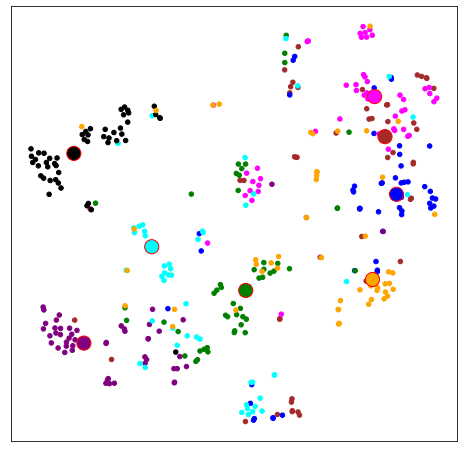

100%|██████████| 8/8 [00:19<00:00,  2.49s/it]
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


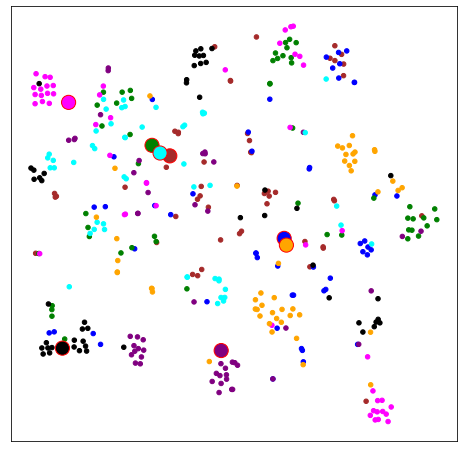

In [15]:
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def vont(X_for_embeds, y_for_embeds, X_test, y_test, players, num_players = 20):
  k_shot_embeddings_list = []
  test_embeddings_list = []

  player_subset = np.random.choice(players, num_players, replace = False)

  centroids_list = []
  ind_to_player = dict()
  player_to_ind = dict()

  y_for_embeds_list_subset = []
  y_test_list_subset = []

  colors = ['brown', 'blue', 'green', 'purple', 'magenta', 'cyan', 'black', 'orange']

  centroids_players_list = []

  for i, player in enumerate(tqdm(player_subset)):
    ind_to_player[i] = player
    player_to_ind[player] = i

    # 1 - white game, 0 - black game
    player_white_games_inds = np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 1)
    player_black_games_inds = np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 0)

    player_white_games = X_for_embeds[player_white_games_inds]
    player_black_games = X_for_embeds[player_black_games_inds]

    y_for_embeds_list_subset.append(y_for_embeds[player_white_games_inds])

    X_k_shot_player = torch.cat((games_to_planes(player_white_games, black = False), games_to_planes(player_black_games, black = True)), dim = 0)
    k_shot_player_embeddings = model(X_k_shot_player).detach().numpy()

    player_centroid = np.mean(k_shot_player_embeddings, axis = 0)
    centroids_list.append(player_centroid)

    player_white_games_test_inds = np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 1)
    player_black_games_test_inds = np.logical_and(y_for_embeds[:,0] == player, y_for_embeds[:,1] == 0)

    player_white_games_test = X_test[player_white_games_test_inds]
    player_black_games_test = X_test[player_black_games_test_inds]

    y_test_list_subset.append(y_test[player_white_games_test_inds])
    y_test_list_subset.append(y_test[player_black_games_test_inds])

    X_test_player = torch.cat((games_to_planes(player_white_games_test, black = False), games_to_planes(player_black_games_test, black = True)), dim = 0)
    test_player_embeddings = model(X_test_player).detach().numpy()

    test_embeddings_list.append(test_player_embeddings)
    centroids_players_list.append(player)

  test_embeddings = np.concatenate(test_embeddings_list, axis = 0)
  centroids = np.array(centroids_list) 

  y_for_embeds_subset = np.concatenate(y_for_embeds_list_subset, axis = 0)
  y_test_subset = np.concatenate(y_test_list_subset, axis = 0)
  centroids_players = np.array(centroids_players_list)

  projected = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, metric = 'cosine').fit_transform(np.concatenate((test_embeddings, centroids), axis=0))

  projected_k_shot = projected[:len(test_embeddings)]
  projected_centroids = projected[len(test_embeddings):]


  fig, ax = plt.subplots(figsize = (8,8));

  plt.scatter(projected_k_shot[:, 0], projected_k_shot[:,1], s=20, c = [colors[player_to_ind[y[0]]] for y in y_test_subset]);
  plt.scatter(projected_centroids[:, 0], projected_centroids[:,1], s=200, edgecolors="red", c = [colors[player_to_ind[y]] for y in centroids_players]);
  
  ax.set_xticks([]);
  ax.set_yticks([]);

  plt.show();

vont(X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, seen_players, num_players = 8)
vont(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players, num_players = 8)

# 40 epochs - 40 x 20 - 10 moves - cosine similarity

In [33]:
seen_accuracy = k_shot_analysis(X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, seen_players, cosine = True)

100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


In [34]:
print(f"Seen players - model: {seen_accuracy} | random: {1/len(seen_players)} | proportion: {seen_accuracy*len(seen_players)}")

Seen players - model: 0.1335 | random: 0.0025 | proportion: 53.400000000000006


In [50]:
unseen_accuracy = k_shot_analysis(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players, cosine = True)

100%|██████████| 935/935 [26:38<00:00,  1.71s/it]


In [51]:
print(f"Unseen players - model: {unseen_accuracy} | random: {1/len(unseen_players)} | proportion: {unseen_accuracy*len(unseen_players)}")

Unseen players - model: 0.0273475935828877 | random: 0.0005347593582887701 | proportion: 51.14


# 40 epochs - 40 x 20 - 20 moves - cosine similarity


In [20]:
seen_accuracy = k_shot_analysis(X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, seen_players, cosine = True)

100%|██████████| 200/200 [10:40<00:00,  3.20s/it]


In [21]:
print(f"Seen players - model: {seen_accuracy} | random: {1/len(seen_players)} | proportion: {seen_accuracy*len(seen_players)}")

Seen players - model: 0.12945 | random: 0.0025 | proportion: 51.78


In [14]:
unseen_accuracy = k_shot_analysis(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players, cosine = True)

100%|██████████| 935/935 [34:10<00:00,  2.19s/it]


In [15]:
print(f"Unseen players - model: {unseen_accuracy} | random: {1/len(unseen_players)} | proportion: {unseen_accuracy*len(unseen_players)}")

Unseen players - model: 0.02249197860962567 | random: 0.0005347593582887701 | proportion: 42.06


# 40 epochs - 40 x 20 - 20 moves

In [ ]:
seen_accuracy = k_shot_analysis(X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, seen_players)

100%|██████████| 200/200 [13:08<00:00,  3.94s/it]


In [ ]:
print(f"Seen players - model: {seen_accuracy} | random: {1/len(seen_players)} | proportion: {seen_accuracy*len(seen_players)}")

Seen players - model: 0.1271 | random: 0.0025 | proportion: 50.839999999999996


In [ ]:
unseen_accuracy = k_shot_analysis(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players)

100%|██████████| 935/935 [46:26<00:00,  2.98s/it]


In [ ]:
print(f"Unseen players - model: {unseen_accuracy} | random: {1/len(unseen_players)} | proportion: {unseen_accuracy*len(unseen_players)}")

Unseen players - model: 0.026898395721925133 | random: 0.0005347593582887701 | proportion: 50.3


# 40 epochs - 40 x 20 - 10 moves

In [ ]:
seen_accuracy = k_shot_analysis(X_seen_for_embeds, y_seen_for_embeds, X_seen_test, y_seen_test, seen_players)

100%|██████████| 200/200 [08:02<00:00,  2.41s/it]


In [ ]:
print(f"Seen players - model: {seen_accuracy} | random: {1/len(seen_players)} | proportion: {seen_accuracy*len(seen_players)}")

Seen players - model: 0.13015 | random: 0.0025 | proportion: 52.059999999999995


In [ ]:
unseen_accuracy = k_shot_analysis(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players)

100%|██████████| 935/935 [37:52<00:00,  2.43s/it]


In [ ]:
print(f"Unseen players - model: {unseen_accuracy} | random: {1/len(unseen_players)} | proportion: {unseen_accuracy*len(unseen_players)}")

Unseen players - model: 0.027625668449197862 | random: 0.0005347593582887701 | proportion: 51.660000000000004


# 100 epochs - 10 x 10

In [ ]:
print(f"Seen players - model: {seen_accuracy} | random: {1/len(seen_players)} | proportion: {seen_accuracy*len(seen_players)}")

Seen players - model: 0.0882 | random: 0.0025 | proportion: 35.28


In [ ]:
unseen_accuracy = k_shot_analysis(X_unseen_for_embeds, y_unseen_for_embeds, X_unseen_test, y_unseen_test, unseen_players)

In [ ]:
print(f"Unseen players - model: {unseen_accuracy} | random: {1/len(unseen_players)} | proportion: {unseen_accuracy*len(unseen_players)}")

Unseen players - model: 0.018962566844919787 | random: 0.0005347593582887701 | proportion: 35.46
